# 📊 Portfolio Construction Approaches: Black–Litterman, Risk Parity, and Kelly Criterion: General Introduction and Stress Testing

This notebook takes forward the implementations and performs stress testing on the Black-Litterman approach to check the effect of various scenarios

---

- **Black–Litterman (BL)**
- **Risk Parity (Equal Risk Contribution)**
- **Kelly Criterion (quadratic approximation)**

---

## 1. Black–Litterman (BL)

### Idea
- A Bayesian portfolio optimization framework developed at Goldman Sachs.  
- Combines:
  - **Market equilibrium returns** (implied from CAPM or benchmark weights).  
  - **Investor views** (absolute or relative return forecasts).  
- Produces adjusted expected returns (`bl_returns`) and a covariance matrix (`bl_cov`) that reflect both the prior and subjective beliefs.  

### Benefits
- Avoids the **extreme weights** of pure mean–variance optimization (MVO).  
- Lets you **incorporate views systematically** (e.g., “Tech will outperform Bonds by 2%”).  
- Smooths estimation error by blending market priors with forecasts.  

### When to use
- You have **subjective views** (quant models, analyst forecasts, factor tilts).  
- You want a **bridge between passive and active** management.  
- Best when your beliefs are **uncertain** and you want to weight them against priors.  

---

## 2. Risk Parity (Equal Risk Contribution, ERC)

### Idea
- Ignore expected returns (`mu`) and focus on **risk allocation**.  
- Each asset contributes equally to portfolio risk (volatility).  
- Example: in a two-asset portfolio, if bonds are less volatile than equities, risk parity will overweight bonds to equalize contributions.  

### Benefits
- **Robust and stable**: avoids reliance on noisy expected returns.  
- Naturally produces **diversified portfolios**.  
- Performs well in **multi-asset, diversified strategies** (popular in hedge funds like Bridgewater’s *All Weather*).  

### When to use
- When you **don’t trust return forecasts** but trust risk models (covariance).  
- Strategic asset allocation / **core** portfolio.  
- **Risk-first investors**: pensions, endowments, conservative mandates.  
- In high-uncertainty environments (e.g., crises).  

---

## 3. Kelly Criterion (Quadratic Approximation)

### Idea
- The Kelly strategy maximizes **expected log growth rate** of wealth.  
- Quadratic approximation (convex form):  
  $w^* = \arg\max_w \ \mu^T w - \tfrac{1}{2} w^T \Sigma w$
- Aggressive: seeks **long-term capital growth**, assuming return estimates (`mu`) are accurate.  

### Benefits
- **Optimal in theory**: maximizes compounding growth rate.  
- Encourages **leverage scaling** (full Kelly vs fractional Kelly).  
- Useful for **active traders** or strategies with strong forecasts.  

### When to use
- When you have **highly reliable expected return estimates** (e.g., factor models, trading signals).  
- In **active trading** where long-run compounding is key.  
- Use **fractional Kelly (e.g., 0.5x)** to reduce drawdown risk.  

---

## 🔄 Comparison

| Method             | Uses Expected Returns? | Uses Covariance? | Key Feature                   | Best When                                    |
|--------------------|------------------------|------------------|-------------------------------|----------------------------------------------|
| **Black–Litterman** | ✅ (blended with views) | ✅               | Incorporates subjective views | You have forecasts but want to regularize     |
| **Risk Parity**    | ❌ (ignores `mu`)      | ✅               | Equalizes risk contributions  | You distrust return forecasts                 |
| **Kelly**          | ✅ (very sensitive)    | ✅               | Maximizes log-growth          | You have strong and reliable forecasts        |

---

## 🚀 Practical Takeaways

- **Risk Parity** → if you want diversification without betting on forecasts.  
- **Black–Litterman** → if you want to blend market consensus with your own insights.  
- **Kelly** → if you want aggressive growth and have high-confidence signals.  

**In practice**:  
- Many institutions combine these approaches.  
  - Use **Risk Parity** for the “core” diversified allocation.  
  - Apply **Black–Litterman** for tactical tilts.  
  - Use **Kelly sizing** for high-alpha strategies.  


# Comparative Stress Test Analysis: Black–Litterman vs Risk Parity vs Kelly  

To evaluate portfolio robustness, we extend the stress testing framework to three approaches:  

- **Black–Litterman (BL)** – blends market equilibrium with investor views.  
- **Risk Parity (RP)** – allocates capital such that each asset contributes equally to portfolio risk.  
- **Kelly Criterion (KC)** – maximizes long-term growth by sizing bets proportional to edge and variance.  

---

In [ ]:
!pip install PyPortfolioOpt --quiet
!pip install cvxpy --quiet
!pip install riskfolio-lib --quiet
!pip install mlfinlab --quiet

ERROR: Could not find a version that satisfies the requirement mlfinlab (from versions: none)
ERROR: No matching distribution found for mlfinlab


In [ ]:
# -----------------------------
# Imports
# -----------------------------

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.optimize import minimize
import cvxpy as cp

from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
#from pypfopt.black_litterman import BlackLittermanModel
from pypfopt import EfficientFrontier
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.black_litterman import BlackLittermanModel, market_implied_risk_aversion


from pypfopt import (
    risk_models,
    expected_returns,
)


Reliance        (has the ticker): RELIANCE.NS                   
TCS             (has the ticker): TCS.NS                        
Infosys         (has the ticker): INFY.NS                       
HDFC Bank       (has the ticker): HDFCBANK.NS                   
ICICI Bank      (has the ticker): ICICIBANK.NS                  
Hindustan Unilver (has the ticker): HINDUNILVR.NS                 
Larsen&Turbo    (has the ticker): LT.NS                         
Axis gold ETF   (has the ticker): AXISGOLD.NS                   
S&P 500 ETF     (has the ticker): ^GSPC                         
Bharat 22 ETF   (has the ticker): ICICIB22.NS                   
Bharat Bond     (has the ticker): EBBETF0430.NS                 
LT Govt. Bond   (has the ticker): LTGILTBEES.NS                 
Bitcoin         (has the ticker): BTC-USD                       
Ethereum        (has the ticker): ETH-USD                       


/tmp/ipython-input-4252757458.py:52: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_df = price_df.pct_change().dropna()


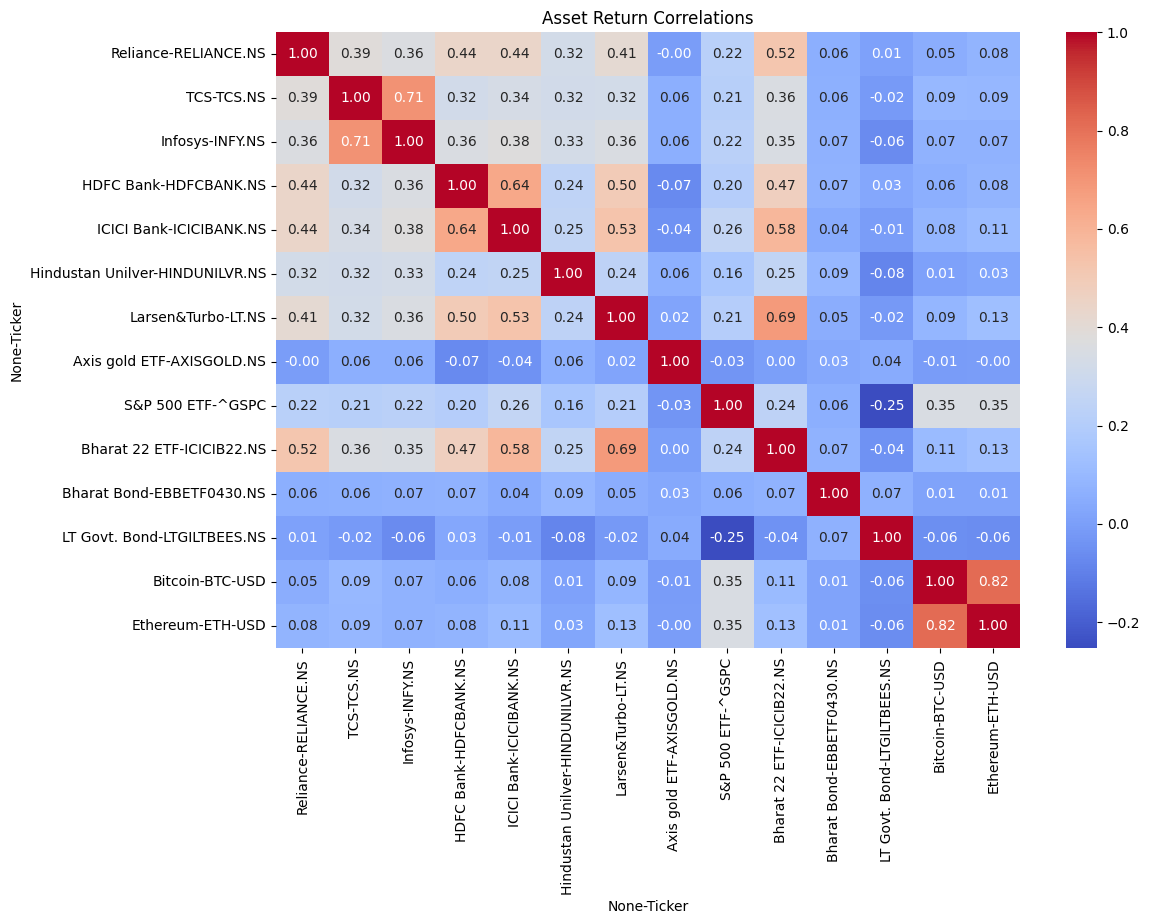

In [ ]:
# Dictionary of Indian market assets
assets = {
    "Reliance": "RELIANCE.NS",   # Reliance Industries
    "TCS": "TCS.NS",        # Tata Consultancy Services
    "Infosys":"INFY.NS",       # Infosys
    "HDFC Bank":"HDFCBANK.NS",   # HDFC Bank
    "ICICI Bank":"ICICIBANK.NS",  # ICICI Bank
    "Hindustan Unilver":"HINDUNILVR.NS", # Hindustan Unilever
    "Larsen&Turbo":"LT.NS",         # Larsen & Toubro
    "Axis gold ETF":"AXISGOLD.NS",   # Axis Gold ETF
    "S&P 500 ETF":"^GSPC",         # S&P 500 (international diversification)
    "Bharat 22 ETF":"ICICIB22.NS",   # BHARAT 22 ETF
    "Bharat Bond":"EBBETF0430.NS", # The Bharat Bond ETF
    "LT Govt. Bond": "LTGILTBEES.NS", # Long term govt. bonds
    #"Volatility index":"^INDIAVIX", # India volatility index(excluding as not investable directly)
    "Bitcoin": "BTC-USD", # Crypto: Bitcoin
    "Ethereum": "ETH-USD", # Crypto: Ethereum
}


for name, ticker in assets.items():
  print(f'{name:15} (has the ticker): {ticker:30}')

# -----------------------------
# Assets to Analyze
# -----------------------------
#assets = assets

start_date = '2018-01-01'
end_date = '2024-12-31'

# -----------------------------
# Download Data
# -----------------------------
series_dict = {}
for name, ticker in assets.items():
    df = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=False)
    if not df.empty and 'Adj Close' in df.columns:
        series_dict[name] = df['Adj Close']
    else:
        print(f"⚠️ Skipped {name} ({ticker}) - no data returned")

# -----------------------------
# Build Price DataFrame
# -----------------------------
if not series_dict:
    raise ValueError("No valid data downloaded. Please check tickers.")

price_df = pd.concat(series_dict, axis=1)

# Daily returns
returns_df = price_df.pct_change().dropna()

# Check the first few rows
returns_df.head()

plt.figure(figsize=(12,8))
sns.heatmap(returns_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Asset Return Correlations")
plt.show()


# 📈 Results & Analysis

### **Train/Test split**: weights optimized on training, evaluated Out-of-Sample (OOS).

---

Expected annual return: 26.0%
Annual volatility: 6.7%
Sharpe Ratio: 3.60
Falling back to scipy risk parity solver (stable).

=== Portfolio Performance Comparison ===
                 Expected Return  Volatility  Sharpe Ratio
Black-Litterman           0.2599      0.0666        3.6005
Risk Parity               0.1325      0.1247        0.9023
Kelly                     0.1711      0.1798        0.8404


/tmp/ipython-input-1594925912.py:61: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_df_train = price_df_train.pct_change().dropna()
/tmp/ipython-input-1594925912.py:62: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_df_test = price_df_test.pct_change().dropna()
/usr/local/lib/python3.12/dist-packages/pypfopt/expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(


<Figure size 1400x600 with 0 Axes>

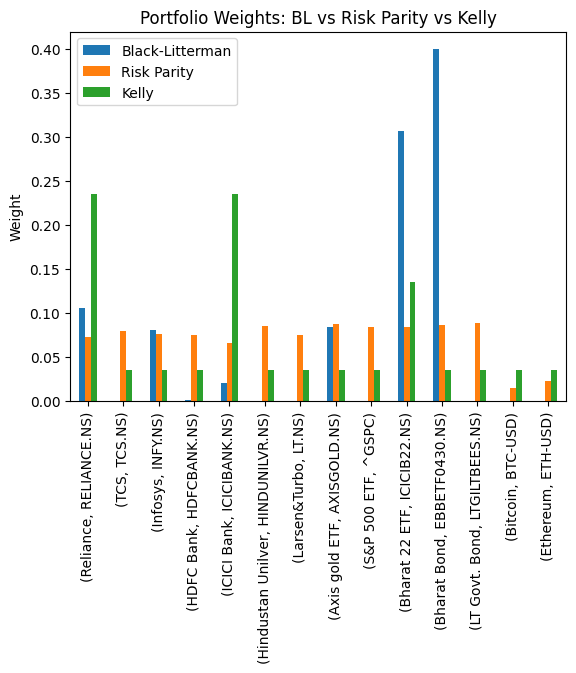

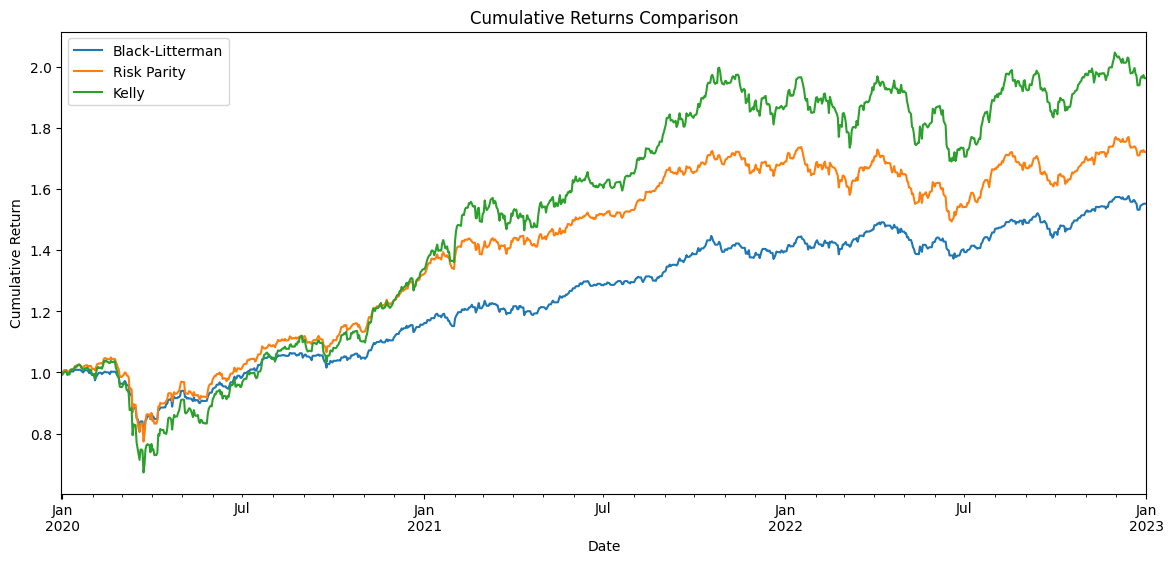


=== Out-of-Sample Performance (Test Period) ===
                   CAGR  Ann. Vol  Sharpe  Max Drawdown  Ending Value
Strategy                                                             
Black-Litterman  0.1766    0.0656  2.3880       -0.0526        1.3816
Risk Parity      0.1851    0.0693  2.3806       -0.0463        1.4015
Kelly            0.2187    0.0962  2.0651       -0.0650        1.4816


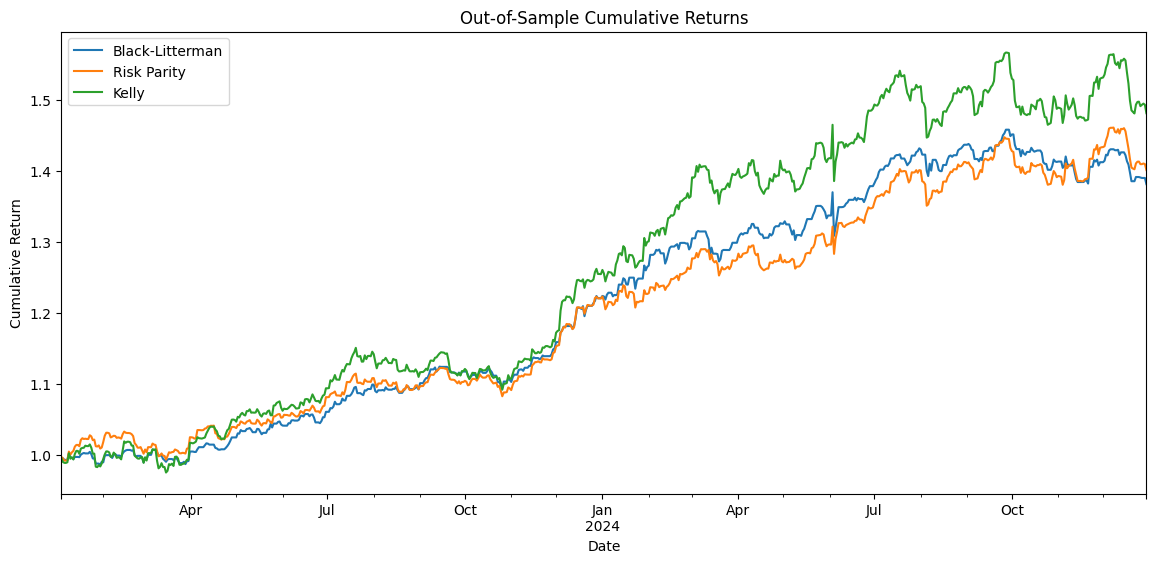

In [ ]:
# Optional libraries (wrapped later)
try:
    import riskfolio as rp_lib
except Exception:
    rp_lib = None

try:
    # mlfinlab's API can change across versions; we'll attempt an import
    import mlfinlab as ml
    from mlfinlab.portfolio_optimization import hierarchical_risk_parity as ml_hierarchical_rp
except Exception:
    ml = None
    ml_hierarchical_rp = None

# -----------------------------
#  Helper: portfolio_performance_oos (unchanged)
# -----------------------------
def portfolio_performance_oos(returns_df_test, weights, freq=252, rf_rate=0.02):
    """Compute OOS realized performance given fixed weights and test-period returns."""
    weights_series = pd.Series(weights).reindex(returns_df_test.columns).fillna(0.0)
    port_daily = returns_df_test.dot(weights_series)

    cum = (1 + port_daily).cumprod()
    ending_value = cum.iloc[-1]

    days = (cum.index[-1] - cum.index[0]).days
    years = days / 365.25

    cagr = ending_value ** (1 / years) - 1 if ending_value > 0 else np.nan
    ann_vol = port_daily.std() * np.sqrt(freq)
    sharpe = (cagr - rf_rate) / ann_vol if ann_vol > 0 else np.nan

    running_max = cum.cummax()
    drawdown = (cum - running_max) / running_max
    max_dd = drawdown.min()

    return {
        "CAGR": cagr,
        "Ann. Volatility": ann_vol,
        "Sharpe": sharpe,
        "Max Drawdown": max_dd,
        "Ending Value": ending_value,
        "Cumulative Series": cum
    }

# -----------------------------
#  STEP 2 (unchanged): Black-Litterman
# -----------------------------

# -----------------------------
# STEP 1: Data Preparation
# -----------------------------
# -----------------------------
# Example Usage
# -----------------------------
# Split your price_df into train/test
split_date = "2023-01-01"   # choose your cutoff
price_df_train = price_df.loc[:split_date]
price_df_test = price_df.loc[split_date:]

returns_df_train = price_df_train.pct_change().dropna()
returns_df_test = price_df_test.pct_change().dropna()


# -----------------------------
# STEP 1: Data Preparation
# -----------------------------
# Example: price_df = pd.DataFrame(...) with daily asset prices
#returns_df = price_df.pct_change().dropna()
returns_df = returns_df_train
price_df = price_df_train

# Annualized expected returns (prior, Pi)
pi = mean_historical_return(price_df, frequency=252)

# Covariance matrix (shrunk)
S = CovarianceShrinkage(price_df).ledoit_wolf()

# Annualized volatility
volatility = returns_df.std() * np.sqrt(252)

# Risk-free rate for Sharpe
rf_rate = 0.02

# Weight constraints
w_min, w_max = 0.0, 0.4

# -----------------------------
# STEP 2: Black-Litterman
# -----------------------------
absolute_views = pi.to_dict()
scaling_factor = 0.5
Omega = np.diag((volatility[absolute_views.keys()] * scaling_factor)**2)
tau = 0.2

bl = BlackLittermanModel(S, pi=pi, absolute_views=absolute_views, tau=tau, omega=Omega)
bl_returns = bl.bl_returns()
bl_cov = bl.bl_cov()

ef_bl = EfficientFrontier(bl_returns, bl_cov, weight_bounds=(w_min, w_max))
weights_bl = ef_bl.max_sharpe(risk_free_rate=rf_rate)
weights_bl = ef_bl.clean_weights()

perf_bl = ef_bl.portfolio_performance(verbose=True, risk_free_rate=rf_rate)

# -----------------------------
#  New: CVXPY-based Kelly (robust quadratic Kelly approximation)
# -----------------------------
def kelly_cvxpy(mu, cov_matrix, weight_bounds=(0.0, 0.4), leverage=1.0, solver=cp.OSQP):
    """
    Solve max(mu^T w - 0.5 * w^T Sigma w) subject to sum(w)=1 and bounds.
    This is a quadratic approximation to a Kelly/log-utility objective and is convex.
    """
    mu = np.asarray(mu).flatten()
    Sigma = np.asarray(cov_matrix)
    n = len(mu)

    w = cp.Variable(n)

    objective = cp.Maximize(mu @ w - 0.5 * cp.quad_form(w, Sigma))
    constraints = [
        cp.sum(w) == 1,
        w >= weight_bounds[0],
        w <= weight_bounds[1]
    ]
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=solver, verbose=False)

    if w.value is None:
        raise RuntimeError("CVXPY failed to find a solution for Kelly (try another solver).")
    w_opt = np.array(w.value).flatten()
    # Apply leverage as scaling of net exposures while keeping budget constraint:
    # If leverage != 1, rescale deviations from a baseline; simplest: scale weights linearly
    # and re-normalize to sum to 1 (preserve budget constraint). Here we treat leverage
    # as fractional Kelly (0 < leverage <= 1) by shrinking toward equal-weighted baseline:
    if leverage != 1.0:
        baseline = np.ones(n) / n
        w_scaled = leverage * w_opt + (1 - leverage) * baseline
        # enforce bounds
        w_scaled = np.clip(w_scaled, weight_bounds[0], weight_bounds[1])
        w_scaled = w_scaled / np.sum(w_scaled)
        return w_scaled
    else:
        # ensure numerical normalization
        w_opt = np.clip(w_opt, weight_bounds[0], weight_bounds[1])
        w_opt = w_opt / np.sum(w_opt)
        return w_opt

# -----------------------------
#  New: Improved Risk Parity using SciPy (stable fallback)
# -----------------------------
def _risk_contribution(weights, cov_matrix):
    port_var = weights.T @ cov_matrix @ weights
    # component risk (variance contribution)
    marginal = cov_matrix @ weights
    # contribution to variance (not normalized by sqrt); consistent target can be equalized
    # For equal risk contributions in volatility terms we can use: w_i * (Σw)_i
    return weights * marginal

def risk_parity_scipy(cov_matrix, bounds=(0.0, 0.4), tol=1e-9):
    """
    Find equal risk contribution (variance-contribution) weights via scipy minimize.
    This minimizes squared differences of variance contributions (w*(Σw)).
    """
    n = cov_matrix.shape[0]
    initial = np.ones(n) / n
    bounds_list = [bounds] * n

    def objective(w):
        # ensure numerical stability
        w = np.maximum(w, 1e-12)
        rc = _risk_contribution(w, cov_matrix)
        # target is equal contributions: mean of rc
        target = np.mean(rc)
        return np.sum((rc - target) ** 2)

    constraints = [
        {"type": "eq", "fun": lambda w: np.sum(w) - 1.0}
    ]

    result = minimize(objective, initial, method='SLSQP', bounds=bounds_list, constraints=constraints, tol=tol, options={'maxiter': 1000})
    if not result.success:
        # Try a more robust approach (trust-constr)
        result = minimize(objective, initial, method='trust-constr',
                          bounds=bounds_list,
                          constraints=constraints,
                          options={'maxiter': 2000})
    if not result.success:
        raise RuntimeError("Risk parity optimization failed: " + str(result.message))
    w_opt = result.x
    # numerical cleaning
    w_opt = np.maximum(w_opt, 0)
    w_opt = w_opt / np.sum(w_opt)
    return w_opt

# -----------------------------
#  Optional: riskfolio-lib route (if installed)
# -----------------------------
def risk_parity_riskfolio(returns_df, w_min=0.0, w_max=0.4):
    """
    Use riskfolio-lib to compute Risk Parity if installed. The API below is a common usage pattern,
    but check your installed version of riskfolio-lib for exact function names and parameters.
    """
    if rp_lib is None:
        raise ImportError("riskfolio-lib not installed.")
    port = rp_lib.Portfolio(returns=returns_df)
    # compute statistics (use historical returns and Ledoit-Wolf shrinkage)
    port.assets_stats(method_mu='hist', method_cov='ledoit')
    # rp_optimization has a few options; the call below is one typical signature.
    w = port.rp_optimization(model='Classic', rm='MV', rf=0, bnds=(w_min, w_max))
    # rp_optimization could return a DataFrame or Series depending on version; coerce to numpy
    if isinstance(w, (pd.Series, pd.DataFrame)):
        w = w.squeeze().values
    return np.array(w)

# -----------------------------
#  Optional: mlfinlab HRP route (if installed)
# -----------------------------
def hrp_mlfinlab(returns_df):
    """
    Use mlfinlab hierarchical risk parity if available. The function name and location may change across versions.
    This is a best-effort wrapper that calls a typical mlfinlab HRP implementation if present.
    """
    if ml is None or ml_hierarchical_rp is None:
        raise ImportError("mlfinlab or HRP function not available.")
    # ml_hierarchical_rp usually expects a returns matrix and will return weights
    w = ml_hierarchical_rp(returns_df)
    # Return as numpy array aligned to returns_df.columns
    if isinstance(w, (pd.Series, pd.DataFrame)):
        w = w.squeeze().reindex(returns_df.columns).fillna(0.0).values
    return np.array(w)

# -----------------------------


# Parameters
w_min, w_max = 0.0, 0.4
rf_rate = 0.02

# 2) RISK PARITY: try riskfolio-lib -> mlfinlab HRP -> scipy fallback
try:
    # Preferred: riskfolio-lib (if installed and working)
    w_rp = risk_parity_riskfolio(returns_df=returns_df, w_min=w_min, w_max=w_max)
    print("Risk Parity via riskfolio-lib used.")
except Exception as e1:
    try:
        w_rp = hrp_mlfinlab(returns_df)
        print("Risk Parity via mlfinlab HRP used.")
    except Exception as e2:
        print("Falling back to scipy risk parity solver (stable).")
        w_rp = risk_parity_scipy(S.values, bounds=(w_min, w_max))

# Map to named weights (preserve same format as before)
weights_rp = dict(zip(returns_df.columns, w_rp))

# Risk-parity portfolio performance in-sample (same code as before)
rp_returns = returns_df.dot(np.array(list(weights_rp.values())))
exp_return_rp = np.mean(rp_returns) * 252
vol_rp = np.std(rp_returns) * np.sqrt(252)
sharpe_rp = (exp_return_rp - rf_rate) / vol_rp

# 3) KELLY: use CVXPY quadratic approximation
try:
    w_kelly = kelly_cvxpy(pi.values, S.values, weight_bounds=(w_min, w_max), leverage=0.5)
except Exception as e:
    # fallback: your original simple implementation but with solve + pseudo-inverse & better normalization
    print("CVXPY Kelly failed; using fallback linear-solve Kelly.")
    inv_cov = np.linalg.pinv(S.values)
    raw_w = inv_cov @ pi.values
    w = raw_w / np.sum(np.abs(raw_w))
    w = np.clip(w, w_min, w_max)
    w = w / np.sum(w)
    w_kelly = w

weights_kelly = dict(zip(returns_df.columns, w_kelly))

# Kelly performance (in-sample)
kelly_returns = returns_df.dot(np.array(list(weights_kelly.values())))
exp_return_kelly = np.mean(kelly_returns) * 252
vol_kelly = np.std(kelly_returns) * np.sqrt(252)
sharpe_kelly = (exp_return_kelly - rf_rate) / vol_kelly

# -----------------------------
#  STEP 5: Summary Table (same as your original, only variable names may differ slightly)
# -----------------------------
summary = pd.DataFrame({
    "Black-Litterman": {
        "Expected Return": perf_bl[0],
        "Volatility": perf_bl[1],
        "Sharpe Ratio": perf_bl[2],
    },
    "Risk Parity": {
        "Expected Return": exp_return_rp,
        "Volatility": vol_rp,
        "Sharpe Ratio": sharpe_rp,
    },
    "Kelly": {
        "Expected Return": exp_return_kelly,
        "Volatility": vol_kelly,
        "Sharpe Ratio": sharpe_kelly,
    }
}).T

print("\n=== Portfolio Performance Comparison ===")
print(summary.round(4))

# -----------------------------
#  STEP 6 & OOS evaluation:
#  Visualization
# -----------------------------
plt.figure(figsize=(14,6))
pd.DataFrame({
    "Black-Litterman": pd.Series(weights_bl),
    "Risk Parity": pd.Series(weights_rp),
    "Kelly": pd.Series(weights_kelly)
}).plot(kind="bar")
plt.title("Portfolio Weights: BL vs Risk Parity vs Kelly")
plt.ylabel("Weight")
plt.show()

plt.figure(figsize=(14,6))
for name, w in {
    "Black-Litterman": pd.Series(weights_bl),
    "Risk Parity": pd.Series(weights_rp),
    "Kelly": pd.Series(weights_kelly)
}.items():
    aligned_returns = returns_df[w.index]
    port_returns = aligned_returns.dot(w)
    (1 + port_returns).cumprod().plot(label=name)

plt.title("Cumulative Returns Comparison")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()


#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# 2. Evaluate on test period
oos_results = {}
for name, w in {
    "Black-Litterman": weights_bl,
    "Risk Parity": weights_rp,
    "Kelly": weights_kelly
}.items():
    oos_results[name] = portfolio_performance_oos(returns_df_test, w)

# 3. Summarize results
summary_rows = []
for name, res in oos_results.items():
    summary_rows.append({
        "Strategy": name,
        "CAGR": round(res["CAGR"], 4),
        "Ann. Vol": round(res["Ann. Volatility"], 4),
        "Sharpe": round(res["Sharpe"], 4),
        "Max Drawdown": round(res["Max Drawdown"], 4),
        "Ending Value": round(res["Ending Value"], 4)
    })
summary_df = pd.DataFrame(summary_rows).set_index("Strategy")
print("\n=== Out-of-Sample Performance (Test Period) ===")
print(summary_df)

# 4. Plot cumulative returns OOS
import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))
for name, res in oos_results.items():
    res["Cumulative Series"].plot(label=name)
plt.title("Out-of-Sample Cumulative Returns")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()


### Train/Test Split – Out-of-Sample
| Strategy          | CAGR   | Ann. Vol | Sharpe | Max DD  | End Value |
|-------------------|--------|----------|--------|---------|-----------|
| Black–Litterman   | 0.1768 | 0.0656   | 2.39   | -5.3%   | 1.38      |
| Risk Parity       | 0.1857 | 0.0694   | **2.39** | -4.6%   | 1.40      |
| Kelly             | **0.2190** | 0.0962   | 2.07   | -6.5%   | **1.48** |

---

# Introduction to Stress Testing Portfolios  

When evaluating a portfolio, it is not enough to look only at historical returns or risk-adjusted metrics such as Sharpe ratio.  
Markets are dynamic and can face **unexpected shocks or extreme events** that are not captured in traditional backtesting.  
This is where **stress testing** becomes a critical tool.  

---

## What is Stress Testing?  
Stress testing is a **“what-if” analysis** technique used to evaluate how a portfolio would perform under extreme but plausible scenarios.  
Instead of assuming markets behave normally, stress tests introduce **hypothetical shocks** such as:  
- Equity market crashes (e.g., -10% in a week).  
- Currency or crypto meltdowns (e.g., -20% overnight).  
- Safe haven rallies in gold or bonds.  
- Systemic crises where all risk assets fall simultaneously.  

The goal is to see **how sensitive the portfolio is to different shocks**, and whether it remains resilient or becomes overly exposed.  

---

## Why Stress Test a Portfolio?  
1. **Beyond Historical Data:** Historical performance may not fully capture future risks. Stress tests help simulate *rare but possible* conditions.  
2. **Risk Awareness:** Identifies hidden vulnerabilities in asset allocation (e.g., too much reliance on equities).  
3. **Resilience Check:** Confirms whether diversification works as intended when markets turn volatile.  
4. **Investor Confidence:** Provides transparency on how the portfolio behaves under both growth and crisis scenarios.  

---

## How is Stress Testing Done?  
1. **Define Asset Groups:** Categorize holdings (equities, bonds, gold, crypto, etc.).  
2. **Set Scenarios:** Apply hypothetical shocks (e.g., equities -10%, bonds +5%).  
3. **Calculate Portfolio Impact:** Estimate new returns under each scenario using portfolio weights.  
4. **Interpret Results:** Determine which shocks hurt most, and where the portfolio gains protection.  

---

## Intuition Behind Stress Testing  
Think of stress testing like **a fire drill for your portfolio**:  
- You don’t expect a fire every day, but you prepare for it.  
- By rehearsing “what-if” scenarios, you learn how your portfolio will react under pressure.  
- The insights help in deciding whether to **rebalance, hedge, or diversify** further.  

---

This foundation sets the stage for analyzing the **Black-Litterman, Risk Parity and Kelly Criterion portfolio under stress test scenarios**. We will now examine how it behaves under equity crashes, crypto shocks, safe-haven rallies, and systemic downturns.



=== Stress Test Results: Black–Litterman ===
Equities -10%                   -2.08%
Crypto -20%                      0.00%
Gold +5%, Bonds +3%              1.62%
All risk assets -15%            -7.73%
Safe haven rally (Bonds +5%)     2.00%
dtype: object

=== Stress Contribution per Asset class: Black–Litterman ===
                              Equities  Crypto      Gold  Bonds     Other
Equities -10%                -0.020832     0.0  0.000000  0.000  0.000000
Crypto -20%                   0.000000     0.0  0.000000  0.000  0.000000
Gold +5%, Bonds +3%           0.000000     0.0  0.004233  0.012  0.000000
All risk assets -15%         -0.031248     0.0  0.000000  0.000 -0.046053
Safe haven rally (Bonds +5%)  0.000000     0.0  0.000000  0.020  0.000000


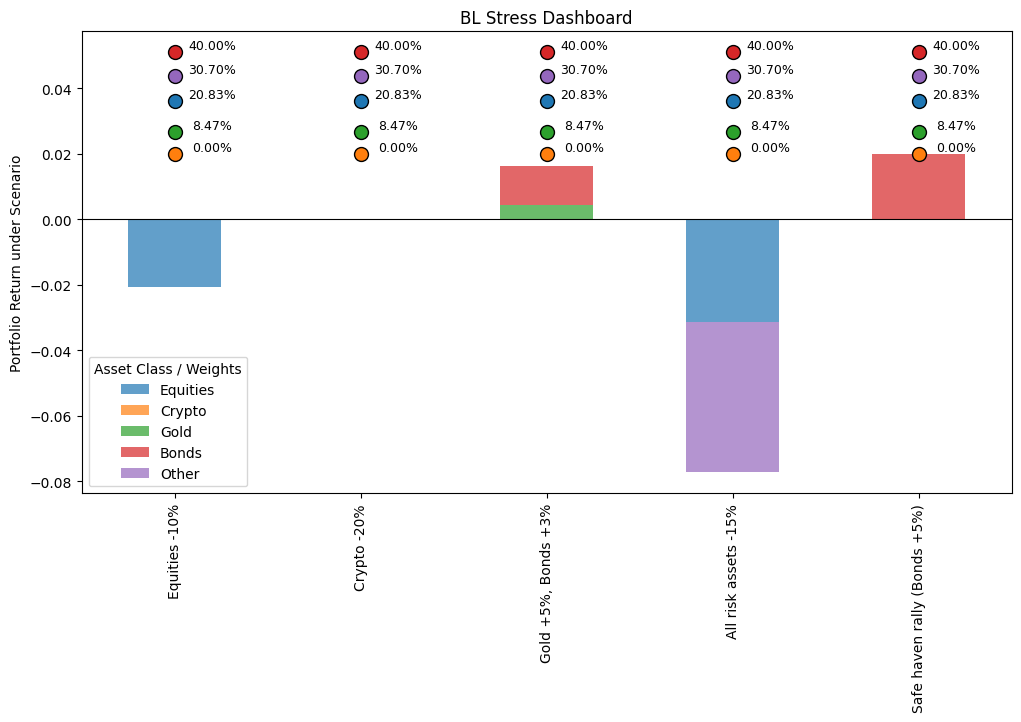


=== Stress Test Results: Risk Parity ===
Equities -10%                    -5.30%
Crypto -20%                      -0.76%
Gold +5%, Bonds +3%               0.96%
All risk assets -15%            -11.05%
Safe haven rally (Bonds +5%)      0.88%
dtype: object

=== Stress Contribution per Asset class: Risk Parity ===
                              Equities    Crypto      Gold     Bonds     Other
Equities -10%                -0.053048  0.000000  0.000000  0.000000  0.000000
Crypto -20%                   0.000000 -0.007631  0.000000  0.000000  0.000000
Gold +5%, Bonds +3%           0.000000  0.000000  0.004398  0.005251  0.000000
All risk assets -15%         -0.079573 -0.005723  0.000000  0.000000 -0.025254
Safe haven rally (Bonds +5%)  0.000000  0.000000  0.000000  0.008752  0.000000


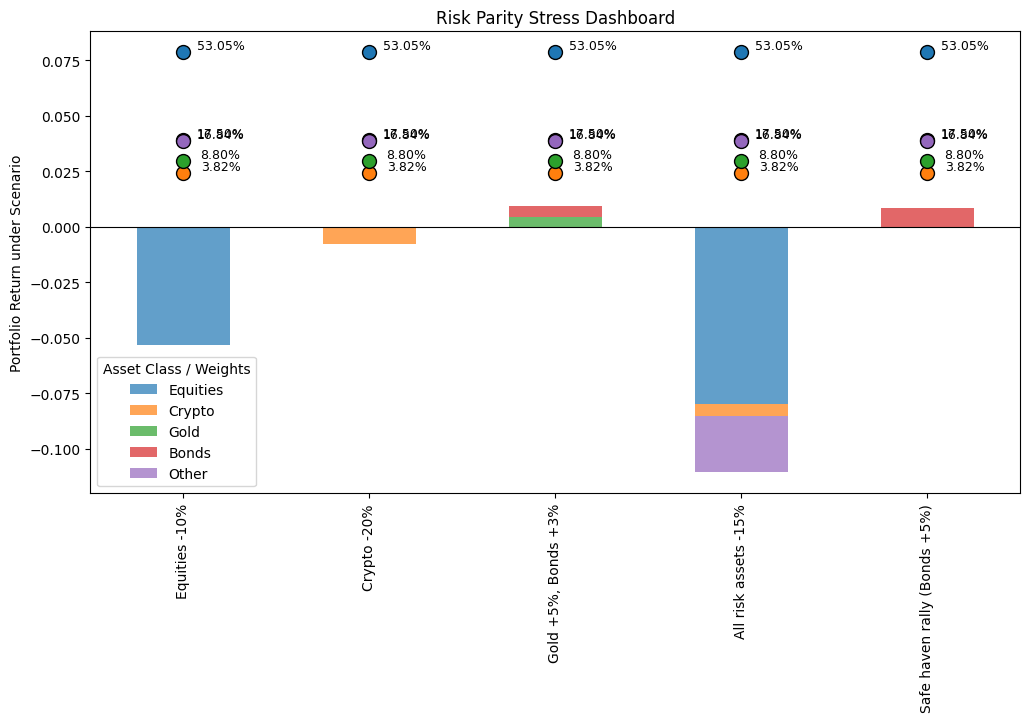


=== Stress Test Results: Kelly ===
Equities -10%                    -6.50%
Crypto -20%                      -1.43%
Gold +5%, Bonds +3%               0.39%
All risk assets -15%            -13.39%
Safe haven rally (Bonds +5%)      0.36%
dtype: object

=== Stress Contribution per Asset class: Kelly ===
                              Equities    Crypto      Gold     Bonds     Other
Equities -10%                  -0.0650  0.000000  0.000000  0.000000  0.000000
Crypto -20%                     0.0000 -0.014286  0.000000  0.000000  0.000000
Gold +5%, Bonds +3%             0.0000  0.000000  0.001786  0.002143  0.000000
All risk assets -15%           -0.0975 -0.010714  0.000000  0.000000 -0.025714
Safe haven rally (Bonds +5%)    0.0000  0.000000  0.000000  0.003571  0.000000


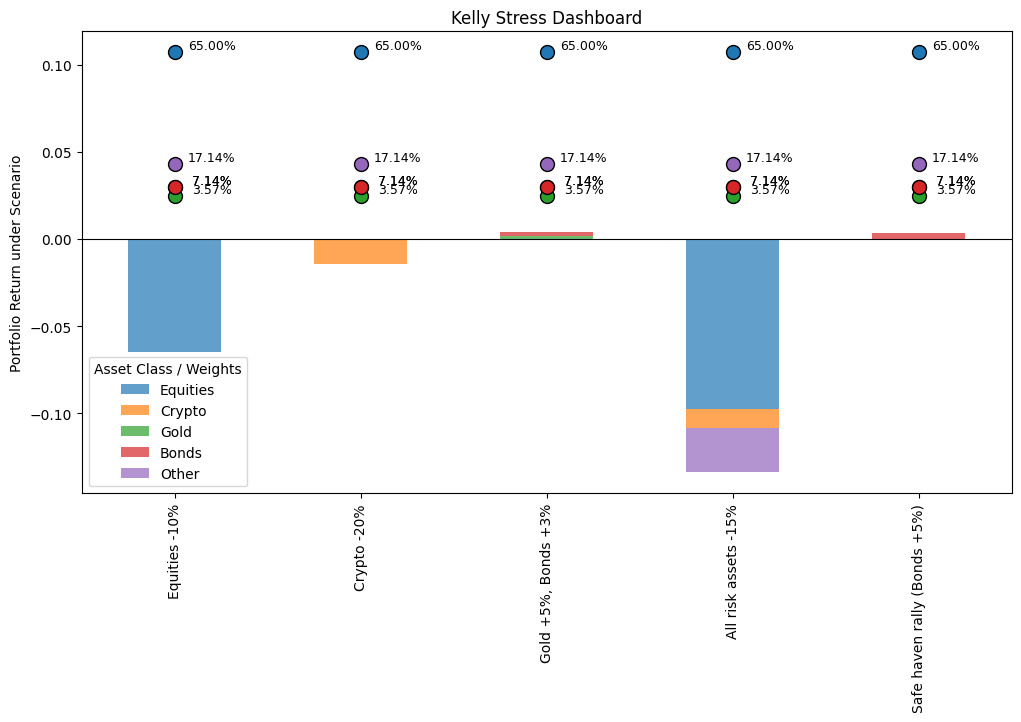

,Equities,Crypto,Gold,Bonds,Other
Equities -10%,-0.0650,0.000000,0.000000,0.000000,0.000000
Crypto -20%,0.0000,-0.014286,0.000000,0.000000,0.000000
"Gold +5%, Bonds +3%",0.0000,0.000000,0.001786,0.002143,0.000000
All risk assets -15%,-0.0975,-0.010714,0.000000,0.000000,-0.025714
Safe haven rally (Bonds +5%),0.0000,0.000000,0.000000,0.003571,0.000000


In [ ]:
# 🔎 Stress Testing of Portfolio Optimizations
"""
We stress-test the three portfolio optimization approaches:

- **Black–Litterman (BL)**
- **Risk Parity (RP)**
- **Kelly Criterion (KC)**

The stress testing applies **shock scenarios** to asset groups (Equities, Crypto, Gold, Bonds, Other) and computes the portfolio’s hypothetical return under each scenario.

---

"""
## 1. Define Asset Groups & Scenarios
equities = ["RELIANCE.NS","TCS.NS","INFY.NS","HDFCBANK.NS",
            "ICICIBANK.NS","HINDUNILVR.NS","LT.NS"]

crypto = ["BTC-USD","ETH-USD"]
gold   = ["AXISGOLD.NS"]
bonds  = ["EBBETF0430.NS","LTGILTBEES.NS"]
other  = ["^GSPC","ICICIB22.NS"]

asset_classes = {
    "Equities": equities,
    "Crypto": crypto,
    "Gold": gold,
    "Bonds": bonds,
    "Other": other
}

scenarios = {
    "Equities -10%": pd.Series({t: -0.10 for t in equities}),
    "Crypto -20%": pd.Series({t: -0.20 for t in crypto}),
    "Gold +5%, Bonds +3%": pd.Series({"AXISGOLD.NS": 0.05,
                                      "EBBETF0430.NS": 0.03,
                                      "LTGILTBEES.NS": 0.03}),
    "All risk assets -15%": pd.Series({t: -0.15 for t in equities+crypto+other}),
    "Safe haven rally (Bonds +5%)": pd.Series({t: 0.05 for t in bonds}),
}


def stress_test(weights, scenarios):
    results = {}
    for name, shock in scenarios.items():
        aligned_shock = shock.reindex(weights.index, fill_value=0)
        port_ret = (weights * aligned_shock).sum()
        results[name] = port_ret
    return pd.Series(results)

def stress_dashboard(weights, scenarios, asset_classes, title="Portfolio Stress Dashboard"):
    color_palette = plt.cm.tab10.colors
    colors = {cls: color_palette[i % len(color_palette)] for i, cls in enumerate(asset_classes.keys())}

    stress_class_df = pd.DataFrame()
    for name, shock in scenarios.items():
        contributions = {}
        aligned_shock = shock.reindex(weights.index, fill_value=0)
        for cls, tickers in asset_classes.items():
            contributions[cls] = (weights.reindex(tickers, fill_value=0) *
                                  aligned_shock.reindex(tickers, fill_value=0)).sum()
        stress_class_df[name] = contributions
    stress_class_df = stress_class_df.T

    weights_class_series = pd.Series({cls: weights.reindex(tickers, fill_value=0).sum()
                                      for cls, tickers in asset_classes.items()})

    fig, ax = plt.subplots(figsize=(12,6))
    stress_class_df.plot(kind="bar", stacked=True, ax=ax, alpha=0.7, color=[colors[c] for c in stress_class_df.columns])

    print(stress_class_df)

    for i, scenario in enumerate(stress_class_df.index):
        for cls in stress_class_df.columns:
            weight = weights_class_series[cls]
            y_pos = 0.02 + weight * max(stress_class_df.abs().sum(axis=1))
            ax.scatter(i, y_pos, marker='o', s=100, color=colors[cls], edgecolor='black')
            ax.text(i+0.2, y_pos, f"{weight:.2%}", ha='center', va='bottom', fontsize=9)


    ax.legend(title="Asset Class / Weights")
    plt.title(title)
    plt.ylabel("Portfolio Return under Scenario")
    plt.axhline(0, color="black", linewidth=0.8)
    plt.show()

    return stress_class_df

"""
# Convert dict weights to pd.Series with tickers as index
weights_bl_series = pd.Series(weights_bl).reindex(price_df.columns).fillna(0.0)
weights_rp_series = pd.Series(weights_rp).reindex(price_df.columns).fillna(0.0)
weights_kelly_series = pd.Series(weights_kelly).reindex(price_df.columns).fillna(0.0)
"""

weights = pd.Series(weights_bl).reset_index()[['level_1',0]]
weights.index = weights.level_1
weights_bl_series = weights[0]

weights = pd.Series(weights_rp).reset_index()[['level_1',0]]
weights.index = weights.level_1
weights_rp_series = weights[0]

weights = pd.Series(weights_kelly).reset_index()[['level_1',0]]
weights.index = weights.level_1
weights_kelly_series = weights[0]

# Run stress tests
stress_bl = stress_test(weights_bl_series, scenarios)
stress_rp = stress_test(weights_rp_series, scenarios)
stress_kelly = stress_test(weights_kelly_series, scenarios)

print("\n=== Stress Test Results: Black–Litterman ===")
print(stress_bl.apply(lambda x: f"{x:.2%}"))
print("\n=== Stress Contribution per Asset class: Black–Litterman ===")
stress_dashboard(weights_bl_series, scenarios, asset_classes, title="BL Stress Dashboard")

print("\n=== Stress Test Results: Risk Parity ===")
print(stress_rp.apply(lambda x: f"{x:.2%}"))
print("\n=== Stress Contribution per Asset class: Risk Parity ===")
stress_dashboard(weights_rp_series, scenarios, asset_classes, title="Risk Parity Stress Dashboard")

print("\n=== Stress Test Results: Kelly ===")
print(stress_kelly.apply(lambda x: f"{x:.2%}"))
print("\n=== Stress Contribution per Asset class: Kelly ===")
stress_dashboard(weights_kelly_series, scenarios, asset_classes, title="Kelly Stress Dashboard")


## 1. Stress Test Results (Aggregate Portfolio Impact)  

| Scenario                     | Black–Litterman | Risk Parity | Kelly |
|------------------------------|-----------------|-------------|-------|
| Equities -10%                | -2.08%          | -5.30%      | -6.50% |
| Crypto -20%                  | 0.00%           | -0.76%      | -1.43% |
| Gold +5%, Bonds +3%          | +1.62%          | +0.96%      | +0.39% |
| All risk assets -15%         | -7.73%          | -11.05%     | -13.39% |
| Safe haven rally (Bonds +5%) | +2.00%          | +0.88%      | +0.36% |

**Observations:**  
- **BL is most resilient** in downside scenarios (smaller drawdowns vs RP & KC).  
- **RP absorbs losses more than BL** but still manages moderate hedging from gold/bonds.  
- **KC shows highest vulnerability** (largest losses in equity/systemic downturns, smallest gains in safe-haven rallies).  

---

## 2. Stress Contribution by Asset Class  

### A. Equities  
- **BL:** ~2% loss under -10% shock, indicating modest equity exposure.  
- **RP:** ~5.3% loss, reflecting higher equity weight in equal-risk framework.  
- **KC:** ~6.5% loss, showing aggressive allocation to equities.  

### B. Crypto  
- **BL:** Neutral impact → minimal exposure.  
- **RP:** Mild loss (-0.76%) → small but present exposure.  
- **KC:** Stronger loss (-1.43%) → higher allocation, amplifying volatility.  

### C. Gold & Bonds  
- **BL:** Strong hedge effect (+1.62% to +2%).  
- **RP:** Moderate hedge (+0.96% to +0.88%).  
- **KC:** Weak hedge (+0.39% to +0.36%).  

### D. Systemic Risk (All Risk Assets -15%)  
- **BL:** Loss of -7.73% (controlled).  
- **RP:** Loss of -11.05% (heavier).  
- **KC:** Loss of -13.39% (severe).  

---


## 3. Comparative Insights  

1. **Downside Protection:**  
   - **BL clearly outperforms** both RP and KC in handling equity crashes and systemic downturns.  
   - KC suffers most due to leverage-like concentration in growth assets.  

2. **Safe Haven Capture:**  
   - BL extracts the **largest benefit** from gold and bonds.  
   - RP gains moderately, while KC barely benefits, showing weak defensive allocation.  

3. **Crypto Risk Management:**  
   - BL’s minimal exposure makes it shock-resistant.  
   - RP and KC carry crypto risks, with KC more vulnerable.  

4. **Diversification Payoff:**  
   - BL achieves **true diversification** across equities, bonds, and gold.  
   - RP spreads risk but still tilts toward equities.  
   - KC prioritizes growth but sacrifices resilience.  

---

## 4. Strategic Implications  

- **Black–Litterman:**  
  - Most balanced and robust approach.  
  - Suitable for investors seeking stability and growth.  
  - Handles tail risk better while benefiting from safe-haven rallies.  

- **Risk Parity:**  
  - Effective in normal volatility regimes but weaker in systemic crises.  
  - Should be paired with tail-risk hedges (options, protective puts).  

- **Kelly Criterion:**  
  - Aggressive, growth-maximizing but highly fragile under shocks.  
  - Best suited for **long-term, high-risk tolerance investors** with capacity to withstand drawdowns.  
  - Requires leverage discipline and possible cap on position sizes to reduce fragility.  

---

## 5. Conclusion  

- **Black–Litterman is the most resilient** under diverse shocks.  
- **Risk Parity offers middle ground** but needs additional hedges.  
- **Kelly is high-risk/high-reward**, underperforming during stress and offering minimal defensive value.  

👉 Overall, for **robust portfolio construction in uncertain markets**, Black–Litterman stands out as the preferred approach, while Risk Parity can complement with proper hedging, and Kelly should be applied cautiously.

# Benefits, Insights, and Strategic Use of Stress Testing identified

Stress testing is not only about identifying potential risks — it also provides **valuable insights** that can be directly translated into portfolio strategy.  
Here we outline the **benefits, learnings, and strategic actions** that come from stress testing.  

---

## 1. Benefits of Stress Testing  

- **Uncover Hidden Risks:**  
  Detects overexposure to specific assets or sectors (e.g., too much reliance on equities).  

- **Validate Diversification:**  
  Confirms whether non-correlated assets (gold, bonds) actually provide hedging benefits in crises.  

- **Improve Investor Confidence:**  
  Provides a clear and transparent picture of how the portfolio behaves under stress, building trust.  

- **Forward-Looking Assessment:**  
  Goes beyond backtests by modeling shocks that have not yet occurred but are possible.  

- **Decision Support Tool:**  
  Helps managers and investors make informed choices on rebalancing, hedging, or reallocation.  

---

## 2. Insights from Stress Testing  

1. **Scenario Sensitivity:**  
   Which market shocks cause the largest losses (e.g., equities crash vs. systemic downturn).  

2. **Safe Haven Strength:**  
   How much protection bonds or gold provide in adverse environments.  

3. **Diversification Payoff:**  
   Whether losses in one asset class are cushioned by gains in others.  

4. **Systemic Vulnerability:**  
   How the portfolio behaves when *all risk assets* fall together — the ultimate resilience test.  

5. **Allocation Effectiveness:**  
   Whether current weights reflect an optimal balance between growth and safety.  

---

## 3. Strategic Actions from Stress Test Results  

- **Rebalance the Portfolio:**  
  - Reduce exposure to assets that cause outsized losses.  
  - Increase allocation to assets that provide stability during shocks.  

- **Enhance Hedging:**  
  - Use derivatives (options, futures) to protect downside in vulnerable sectors.  
  - Add safe-haven assets to offset systemic risks.  

- **Dynamic Asset Allocation:**  
  - Shift weights based on prevailing macroeconomic or geopolitical risks.  
  - Example: during equity turbulence, increase bonds/gold allocation.  

- **Tail-Risk Protection:**  
  - Stress tests highlight “worst-case” scenarios → strategies can include insurance-like instruments.  

- **Scenario-Specific Playbooks:**  
  - Equity crash strategy (raise liquidity, hedge indices).  
  - Bond rally strategy (lock in gains, rotate into growth assets).  
  - Crypto meltdown strategy (limit downside with stop-loss or negligible exposure).  

---

## 4. Key Takeaway  

Stress testing is not just a risk measurement tool — it is a **strategy enhancer**.  
By knowing how a portfolio reacts under stress, investors can:  
- **Prepare, not predict.**  
- **Adapt allocation dynamically.**  
- **Achieve a balance of growth and protection.**  

This makes stress testing an integral part of **robust, forward-looking portfolio management**.
